# Step 0 -- get the data

In [1]:
!wget https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip -O data.zip

--2016-12-27 10:35:04--  https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip
Resolving d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)... 54.230.216.219, 54.230.216.170, 54.230.216.189, ...
Connecting to d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)|54.230.216.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 333137665 (318M) [application/zip]
Saving to: 'data.zip'

100%[======================================>] 333,137,665 20.9MB/s   in 19s    

2016-12-27 10:35:23 (16.6 MB/s) - 'data.zip' saved [333137665/333137665]



In [2]:
!unzip -q data.zip
!mv data udacity_data
!rm -rf __MACOSX/

Unzip prepared validation and training sets:
* validation set is a custom driving data of the 1st track
* test set is a custom driving data of the 2nd track

In [14]:
!unzip -q data_val.zip
!unzip -q data_test.zip

In [1]:
DATA_TRAIN_FOLDER = 'udacity_data/'
DATA_VAL_FOLDER = 'data_val/'
DATA_TEST_FOLDER = 'data_test/'

# Step 1 -- load data and visualize

In [2]:
import pandas as pd
import numpy as np
import cv2

import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [3]:
train_source = pd.read_csv(DATA_TRAIN_FOLDER + 'driving_log.csv')
train_nonzero = train_source[train_source.steering != 0]
train_zero = (train_source[train_source.steering == 0]).sample(frac=.1)

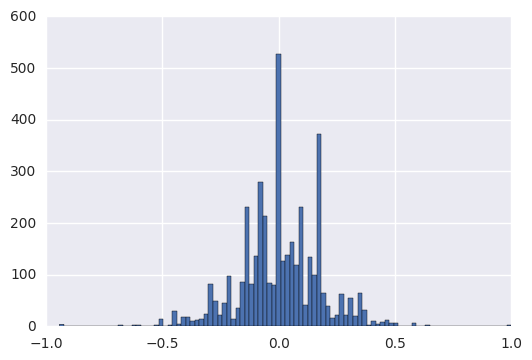

In [4]:
data_train = pd.concat([train_nonzero, train_zero], ignore_index=True)
data_train.steering.hist(bins=100)

In [5]:
names = ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
data_val = pd.read_csv(DATA_VAL_FOLDER + 'driving_log.csv', names=names)
data_test = pd.read_csv(DATA_TEST_FOLDER + 'driving_log.csv', names=names)

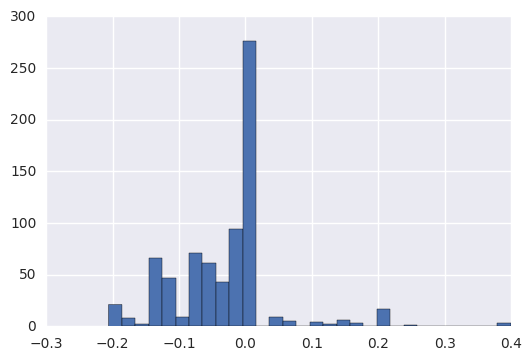

In [6]:
data_val.steering.hist(bins=30)

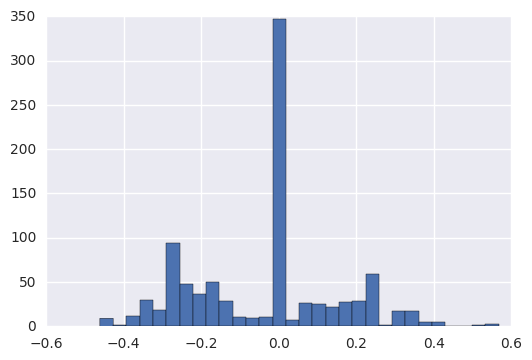

In [7]:
data_test.steering.hist(bins=30)

In [24]:
len(data_train), len(data_val), len(data_test)

(4111, 748, 948)

# Step 2 data generators

In [9]:
input_shape = (64, 64, 3)

In [10]:
def _get_img_and_steering_from_row(row, folder):
    imgpath = row.center.values[0]
    imgpath = imgpath[imgpath.find('IMG'):]
    img = cv2.imread(folder + imgpath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    steering = row.steering.values[0]
    return img, steering


def _get_img_and_steering_from_iloc_row(row, folder):
    imgpath = row.center
    imgpath = imgpath[imgpath.find('IMG'):]
    img = cv2.imread(folder + imgpath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    steering = row.steering
    return img, steering


def _get_flipped_image(img, y):
    img = cv2.flip(img, 1)
    return img, -y


def _get_brightnessed_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    random_bright = .25 + np.random.uniform()
    img[:,:,2] = img[:,:,2] * random_bright
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return img


def _get_translated_image(img, y, trans_range):
    rows, cols, _ = img.shape
    tr_x = trans_range * np.random.uniform() - trans_range/2
    y = y + tr_x/trans_range * 2 *.4
    tr_y = 10 * np.random.uniform() - 10/2
    Trans_M = np.float32([[1,0, tr_x], [0,1, tr_y]])
    img = cv2.warpAffine(img, Trans_M, (cols, rows))
    return img, y


def image_augmentation(img, y):
    if np.random.uniform() < 0.5:
        img, y = _get_flipped_image(img, y)
    img = _get_brightnessed_image(img)
    img, y = _get_translated_image(img, y, 100)
    return img, y


def image_transformation(img):
    img = img[60:-20,:,:]
    img = cv2.resize(img, (input_shape[1], input_shape[0]), interpolation=cv2.INTER_AREA)
    return img

(-0.5, 63.5, 63.5, -0.5)

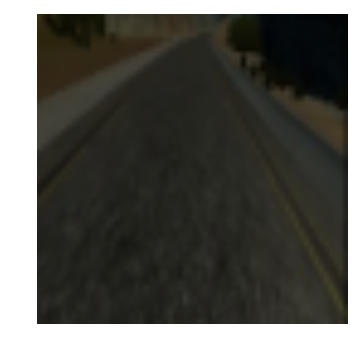

In [11]:
row = data_train.sample()
img, steering = _get_img_and_steering_from_row(row, DATA_TRAIN_FOLDER)
img, steering = image_augmentation(img, steering)
img = image_transformation(img)

plt.imshow(img)
plt.axis('off')

In [12]:
def train_data_generator(batch_size):
    while True:
        X = np.zeros((batch_size, *input_shape), dtype=np.float32)
        y = np.zeros((batch_size,), dtype=np.float32)
        for idx in range(batch_size):
            row = data_train.sample()
            img, steering = _get_img_and_steering_from_row(row, DATA_TRAIN_FOLDER)
            img, steering = image_augmentation(img, steering)
            img = image_transformation(img)
            X[idx], y[idx] = img, steering
        yield X, y

In [13]:
def val_data_generator(batch_size):
    seq_idx = 0
    while True:
        X = np.zeros((batch_size, *input_shape), dtype=np.float32)
        y = np.zeros((batch_size,), dtype=np.float32)
        for idx in range(batch_size):
            row = data_val.iloc[seq_idx]
            img, steering = _get_img_and_steering_from_iloc_row(row, DATA_VAL_FOLDER)
            img = image_transformation(img)
            X[idx], y[idx] = img, steering
            
            seq_idx += 1
            if seq_idx == len(data_val):
                seq_idx = 0
        yield X, y

In [14]:
def test_data_generator(batch_size):
    seq_idx = 0
    while True:
        X = np.zeros((batch_size, *input_shape), dtype=np.float32)
        y = np.zeros((batch_size,), dtype=np.float32)
        for idx in range(batch_size):
            row = data_test.iloc[seq_idx]
            img, steering = _get_img_and_steering_from_iloc_row(row, DATA_TEST_FOLDER)
            img = image_transformation(img)
            X[idx], y[idx] = img, steering
            
            seq_idx += 1
            if seq_idx == len(data_test):
                seq_idx = 0
        yield X, y

# Step 2 -- define the model

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, ELU, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


I also tried NVIDIA, commaai and VGG-like architecture, as well as several custom ones, but this one, provided by [Vivek Yadav](https://github.com/vxy10/P3-BehaviorCloning) is actually the best one for this task. Big thanks!

In [16]:
def get_vivek_model():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape=input_shape))
    model.add(Convolution2D(3,1,1,  border_mode='valid', name='conv0', init='he_normal'))
    model.add(Convolution2D(32,3,3, border_mode='valid', name='conv1', init='he_normal'))
    model.add(ELU())
    model.add(Convolution2D(32,3,3, border_mode='valid', name='conv2', init='he_normal'))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    
    model.add(Convolution2D(64,3,3, border_mode='valid', name='conv3', init='he_normal'))
    model.add(ELU())
    model.add(Convolution2D(64,3,3, border_mode='valid', name='conv4', init='he_normal'))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    
    model.add(Convolution2D(128,3,3, border_mode='valid', name='conv5', init='he_normal'))
    model.add(ELU())
    model.add(Convolution2D(128,3,3, border_mode='valid', name='conv6', init='he_normal'))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(512,name='hidden1', init='he_normal'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Dense(64,name='hidden2', init='he_normal'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Dense(16,name='hidden3',init='he_normal'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Dense(1, name='output', init='he_normal'))
    model.compile(optimizer="adam", loss="mse")
    return model

# Step 3 -- train!

Train on the subset of udacity data with augmentation

Validate on custom data from 1st track

Test on custom data from 2nd track

In [17]:
model = get_vivek_model()
model.fit_generator(
    train_data_generator(50),
    samples_per_epoch=20000,
    nb_epoch=10,
    validation_data=val_data_generator(250),
    nb_val_samples=750,
    callbacks=[ModelCheckpoint(filepath="best_validation.h5", verbose=1, save_best_only=True)]
)

Epoch 1/10
20000/20000 [==============================] - 60s - loss: 0.0518 - val_loss: 0.0100
Epoch 2/10
20000/20000 [==============================] - 58s - loss: 0.0396 - val_loss: 0.0109
Epoch 3/10
20000/20000 [==============================] - 58s - loss: 0.0331 - val_loss: 0.0489
Epoch 4/10
20000/20000 [==============================] - 58s - loss: 0.0279 - val_loss: 0.0109
Epoch 5/10
20000/20000 [==============================] - 58s - loss: 0.0255 - val_loss: 0.0092
Epoch 6/10
20000/20000 [==============================] - 58s - loss: 0.0249 - val_loss: 0.0068
Epoch 7/10
20000/20000 [==============================] - 58s - loss: 0.0242 - val_loss: 0.0085
Epoch 8/10
20000/20000 [==============================] - 58s - loss: 0.0255 - val_loss: 0.0054
Epoch 9/10
20000/20000 [==============================] - 58s - loss: 0.0243 - val_loss: 0.0038
Epoch 10/10
20000/20000 [==============================] - 58s - loss: 0.0243 - val_loss: 0.0081


# Step 4 -- evaluation

Restore best model from intermediate save and use

In [18]:
print('Latest', model.evaluate_generator(val_data_generator(250), 750))
model.load_weights('best_validation.h5')
print('Best', model.evaluate_generator(val_data_generator(250), 750))

Latest 0.00808320178961
Best 0.00384507623191


In [19]:
model.evaluate_generator(test_data_generator(50), 950)

0.0083494499007141908

In [20]:
def get_samples(log, folder):
    for _ in range(10):
        row = log.sample()
        imgpath = row.center.values[0]
        imgpath = imgpath[imgpath.find('IMG'):]
        img = cv2.imread(folder + imgpath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = image_transformation(img)
        print(row.steering.values[0], model.predict(np.expand_dims(img, axis=0))[0])

In [21]:
get_samples(data_val, DATA_VAL_FOLDER)

0.0 [-0.01915371]
-0.02204349 [-0.07885508]
-0.1382363 [-0.13422723]
0.0 [-0.03817816]
0.0 [-0.03485824]
0.0 [ 0.00770417]
-0.1866501 [-0.12932573]
0.0 [ 0.00884948]
0.0 [-0.0196645]
-0.07045718 [-0.04182312]


In [22]:
get_samples(data_test, DATA_TEST_FOLDER)

-0.2389614 [-0.23317344]
0.0 [-0.16454121]
0.0 [-0.03975093]
0.0 [-0.06640729]
0.0 [ 0.03869127]
0.007028675 [ 0.00721287]
0.0 [ 0.02606358]
0.0 [ 0.02242848]
-0.2872807 [-0.3301293]
-0.1713143 [-0.16757624]


# Step 5 -- save and use

In [23]:
import json
with open('model.json', 'w') as f:
    f.write(model.to_json())
model.save_weights('model.h5')